#**Receiver operating characteristic (ROC) Curve**
---
Some insights: \\
- A graphic scheme for binary classification. \\
- On the x-axis you have the false positive rate (FPR) \\
- On the y-axis the true positive rate (TPR) \\
- Each point of the curve is possible threshold \\
- You can choose the threshold you prefer as a trade-off between the TPR and  the FPR \\
- The main output you have are: TPR, FPR and Area Under the Curve (AUC)
- To generate the ROC curve you need two arrays: score and label
- In the score array goes the similarity values returned by the classifier
- In the label array goes the labels set in concert with the decision the \\
classifier should take (i.e. 1 if the binary decision is positive, 0 if negative).
- We refer to the positive and negative decision of the classifier respectively with H1 (or match) and H0 (or mis-match).

**QUESTIONS?** *andrea.monitbeller@unitn.it*

An Example

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

score = np.asarray([1, 0.9, 0.8, 0.7, 0.75, 0.76, 0.88, 0.91, 0.7, 0.55, 0.6,
                    0.2, 0.5, 0.6, 0.7, 0.3, 0.44, 0.55, 0.61, 0.21, 0.5, 0.1])
label = np.asarray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
#compute ROC
fpr, tpr, tau = roc_curve(label, score, drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)

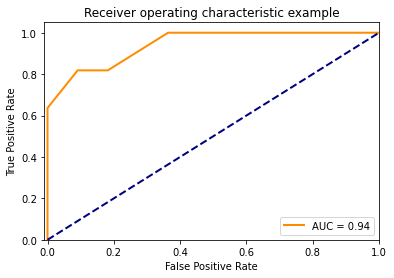

In [3]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

#How do I set the threshold then?
A good threshold has a good trade off between TPR and FPR. Generally, the condition you care about is that your FPR never exceed a value of 0.05. Thus, for the example above:

In [4]:
idx_tpr = np.where((fpr - 0.05) == min(i for i in (fpr - 0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])

For a FPR approximately equals to 0.05 corresponds a TPR equals to 0.82
For a FPR approximately equals to 0.05 corresponds a threshold equals to 0.70
Check FPR 0.09


#**EXAMPLE 2**

Let's apply what we learned to watermarking.

Function to embed/detect spread spectrum and apply a random attack.

In [5]:
from scipy.fft import dct, idct

import random


def embedding(image, mark_size, alpha, v='multiplicative'):
    # Get the DCT transform of the image
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    sign = np.sign(ori_dct)
    ori_dct = abs(ori_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Generate a watermark
    mark = np.random.uniform(0.0, 1.0, mark_size)
    mark = np.uint8(np.rint(mark))
    np.save('mark.npy', mark)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], mark)):
        if v == 'additive':
            watermarked_dct[loc] += (alpha * mark_val)
        elif v == 'multiplicative':
            watermarked_dct[loc] *= 1 + (alpha * mark_val)

    # Restore sign and o back to spatial domain
    watermarked_dct *= sign
    watermarked = np.uint8(idct(idct(watermarked_dct, axis=1, norm='ortho'), axis=0, norm='ortho'))

    return mark, watermarked


def detection(image, watermarked, w, mark_size, v='multiplicative'):
    ori_dct = dct(dct(image, axis=0, norm='ortho'), axis=1, norm='ortho')
    wat_dct = dct(dct(watermarked, axis=0, norm='ortho'), axis=1, norm='ortho')

    # Get the locations of the most perceptually significant components
    ori_dct = abs(ori_dct)
    wat_dct = abs(wat_dct)
    locations = np.argsort(-ori_dct, axis=None)  # - sign is used to get descending order
    rows = image.shape[0]
    locations = [(val // rows, val % rows) for val in locations]  # locations as (x,y) coordinates

    # Generate a watermark
    w_ex = np.zeros(mark_size, dtype=np.float64)

    # Embed the watermark
    watermarked_dct = ori_dct.copy()
    for idx, (loc, mark_val) in enumerate(zip(locations[1:], w)):
        if v == 'additive':
            w_ex[idx] = (wat_dct[loc] - ori_dct[loc]) / alpha
        elif v == 'multiplicative':
            w_ex[idx] = (wat_dct[loc] - ori_dct[loc]) / (alpha * ori_dct[loc])

    return w_ex


def similarity(X, X_star):
    #Computes the similarity measure between the original and the new watermarks.
    s = np.sum(np.multiply(X, X_star)) / np.sqrt(np.sum(np.multiply(X_star, X_star)))
    return s


#this seed was set just to make you obtain the same result
random.seed(3)


def awgn(img, std, seed):
    mean = 0.0  # some constant
    #np.random.seed(seed)
    attacked = img + np.random.normal(mean, std, img.shape)
    attacked = np.clip(attacked, 0, 255)
    return attacked


def blur(img, sigma):
    from scipy.ndimage.filters import gaussian_filter
    attacked = gaussian_filter(img, sigma)
    return attacked


def sharpening(img, sigma, alpha):
    from scipy.ndimage import gaussian_filter

    #print(img/255)
    filter_blurred_f = gaussian_filter(img, sigma)

    attacked = img + alpha * (img - filter_blurred_f)
    return attacked


def median(img, kernel_size):
    from scipy.signal import medfilt
    attacked = medfilt(img, kernel_size)
    return attacked


def resizing(img, scale):
    from skimage.transform import rescale
    x, y = img.shape
    attacked = rescale(img, scale)
    attacked = rescale(attacked, 1 / scale)
    attacked = attacked[:x, :y]
    return attacked


def jpeg_compression(img, QF):
    from PIL import Image
    img = Image.fromarray(img)
    img.save('tmp.jpg', "JPEG", quality=QF)
    attacked = Image.open('tmp.jpg')
    attacked = np.asarray(attacked, dtype=np.uint8)
    os.remove('tmp.jpg')

    return attacked


def random_attack(img):
    i = random.randint(1, 6)
    if i == 1:
        attacked = awgn(img, 5.0, 123)
    elif i == 2:
        attacked = blur(img, [3, 2])
    elif i == 3:
        attacked = sharpening(img, 1, 1)
    elif i == 4:
        attacked = median(img, [3, 5])
    elif i == 5:
        attacked = resizing(img, 0.5)
    elif i == 6:
        attacked = jpeg_compression(img, 75)
    else:
        attacked = None
    return attacked

Get the images

In [20]:
import os
import numpy as np
import cv2

import random

# get required images
if not os.path.isdir('../_Images'):
    !wget -O../ watermarking-images.zip "https://drive.google.com/uc?export=download&id=1GOz-jcICYEFZwMgzZdNEP3j7ZMDXIOuo"
    !unzip -f../ watermarking-images.zip
    !mv -rf _Images..
    !rm../ watermarking-images.zip

--2021-10-11 09:00:09--  https://drive.google.com/uc?export=download&id=1GOz-jcICYEFZwMgzZdNEP3j7ZMDXIOuo
Resolving drive.google.com (drive.google.com)... 216.58.205.78
Connecting to drive.google.com (drive.google.com)|216.58.205.78|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-04-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6n3ajro8r2d2dg7094o4teo95milvhek/1633935600000/05147498317285990661/*/1GOz-jcICYEFZwMgzZdNEP3j7ZMDXIOuo?e=download [following]
--2021-10-11 09:00:10--  https://doc-04-9g-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/6n3ajro8r2d2dg7094o4teo95milvhek/1633935600000/05147498317285990661/*/1GOz-jcICYEFZwMgzZdNEP3j7ZMDXIOuo?e=download
Resolving doc-04-9g-docs.googleusercontent.com (doc-04-9g-docs.googleusercontent.com)... 216.58.209.33
Connecting to doc-04-9g-docs.googleusercontent.com (doc-04-9g-docs.googleusercontent.com)|216.58.209.33|:443... connected.

Import one image

In [7]:
# Read image
im = cv2.imread('../Images/lena.bmp', 0)
print('Image shape: ', im.shape)

Image shape:  (512, 512)


Build a mini dataset of 999 samples for the ROC. \\
**NOTE**: In this example we use Spread Spectrum. 

In [8]:
#some parameters for the spread spectrum
mark_size = 1024
alpha = 24  #0.1
v = 'additive'
# np.random.seed(seed=124)

#scores and labels are two lists we will use to append the values of similarity and their labels
#In scores we will append the similarity between our watermarked image and the attacked one, 
# or  between the attacked watermark and a random watermark
#In labels we will append the 1 if the scores was computed between the watermarked image and the attacked one,
#and 0 otherwise
scores = []
labels = []
#Embed Watermark
mark, watermarked = embedding(im, mark_size, alpha, v)

sample = 0
while sample < 999:
    #fakemark is the watermark for H0
    fakemark = np.random.uniform(0.0, 1.0, mark_size)
    fakemark = np.uint8(np.rint(fakemark))
    #random attack to watermarked image
    res_att = random_attack(watermarked)
    #extract attacked watermark
    w_ex = detection(im, res_att, mark, mark_size, v)
    #compute similarity H1
    scores.append(similarity(mark, w_ex))
    labels.append(1)
    #compute similarity H0
    scores.append(similarity(fakemark, w_ex))
    labels.append(0)
    sample += 1

Compute the ROC

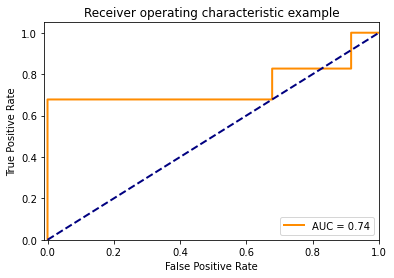

For a FPR approximately equals to 0.05 corresponds a TPR equals to 0.68
For a FPR approximately equals to 0.05 corresponds a threshold equals to 13.17
Check FPR 0.05


In [9]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve, auc

#compute ROC
fpr, tpr, tau = roc_curve(np.asarray(labels), np.asarray(scores), drop_intermediate=False)
#compute AUC
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()
idx_tpr = np.where((fpr - 0.05) == min(i for i in (fpr - 0.05) if i > 0))
print('For a FPR approximately equals to 0.05 corresponds a TPR equals to %0.2f' % tpr[idx_tpr[0][0]])
print('For a FPR approximately equals to 0.05 corresponds a threshold equals to %0.2f' % tau[idx_tpr[0][0]])
print('Check FPR %0.2f' % fpr[idx_tpr[0][0]])

#**EXERCISE 1**

Modify this code with your watermarking method and compute the ROC. Then print the TPR and threshold for FPR == 0.05

In [10]:
# np.random.seed(seed=123)
#import an image
im = cv2.imread('../Images/lena.bmp', 0)
print('Image shape: ', im.shape)
#generate your watermark (if it is necessary)
'''YOUR CODE'''

#scores and labels are two lists we will use to append the values of similarity and their labels
#In scores we will append the similarity between our watermarked image and the attacked one, 
# or  between the attacked watermark and a random watermark
#In labels we will append the 1 if the scores was computed between the watermarked image and the attacked one,
#and 0 otherwise
scores = []
labels = []
#Embed Watermark
'''YOUR CODE'''

sample = 0
while sample < 999:
    #fakemark is the watermark for H0
    fakemark = np.random.uniform(0.0, 1.0, mark_size)
    fakemark = np.uint8(np.rint(fakemark))
    #random attack to watermarked image (you can modify it)
    res_att = random_attack(watermarked)
    #extract attacked watermark

    '''YOUR CODE'''

    #compute similarity H1
    scores.append(similarity(mark, w_ex))
    labels.append(1)
    #compute similarity H0
    scores.append(similarity(fakemark, w_ex))
    labels.append(0)
    sample += 1

#**EXERCISE 2**
To find a better threshold estimation, do not use just one single image. Adapt the code you implement to compute the scores on different images (i.e. Lena, Baboon, etc.)

In [11]:
'''YOUR CODE'''

'YOUR CODE'